In [1]:
#@title Print TF version and GPU stats
import tensorflow as tf
print('TensorFlow version:', tf.__version__)

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
   raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name), '', sep='\n')
!nvidia-smi

TensorFlow version: 2.3.1
Found GPU at: /device:GPU:0

Tue Dec 15 20:22:03 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.79       Driver Version: 460.79       CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce MX250      WDDM  | 00000000:2B:00.0 Off |                  N/A |
| N/A   55C    P0    N/A /  N/A |    182MiB /  2048MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                 

In [2]:
import pandas as pd
import numpy as np

# Loading and preparing data

In [4]:
data = pd.read_csv("../data/normalized_lorenz_0.01.csv")

In [5]:
data.values

array([[ 0.1314481 ,  0.11547217, -2.72166041],
       [ 0.13309505,  0.14538841, -2.72035826],
       [ 0.1378463 ,  0.17578109, -2.71873748],
       ...,
       [-2.11336479, -1.19025243,  2.30984813],
       [-2.02477535, -0.89294199,  2.35453757],
       [-1.91308506, -0.61002014,  2.3426221 ]])

In [6]:
data.shape

(600000, 3)

In [7]:
def split_sequence(sequence, n_steps):
    X, Y = list(), list()
    for i in range(0, len(sequence)-1):
        end_ix = i + n_steps
        if end_ix > len(sequence)-1:
            break
        seq_x, seq_y = sequence[i:end_ix,:], sequence[end_ix,:]
        X.append(seq_x)
        Y.append(seq_y)
    return np.array(X), np.array(Y)

In [8]:
window_size = 20
X, Y = split_sequence(data.values, window_size)
end_train = int(np.round(X.shape[0]*0.6))
end_valid = int(np.round(X.shape[0]*(0.6+0.2)))
train_X = X[:end_train]
train_Y = Y[:end_train]
valid_X = X[end_train:end_valid]
valid_Y = Y[end_train:end_valid]
test_X = X[end_valid::20]
test_Y = Y[end_valid::20]

In [9]:
print('Train X shape - ', train_X.shape, ' train Y shape - ', train_Y.shape)
print('Valid X shape - ', valid_X.shape, ' valid Y shape - ', valid_Y.shape)
print('Test X shape  - ', test_X.shape, '   test Y shape - ', test_Y.shape)

Train X shape -  (359988, 20, 3)  train Y shape -  (359988, 3)
Valid X shape -  (119996, 20, 3)  valid Y shape -  (119996, 3)
Test X shape  -  (6000, 20, 3)    test Y shape -  (6000, 3)


# RNN model creation

In [10]:
from keras import Model, layers, Input
from keras.optimizers import Adam
from keras import backend as K

In [11]:
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 

In [30]:
def build_lstm_model(input_shape, summary=True):
    
    inputs = Input(shape=input_shape)
    
    x = layers.LSTM(32, activation='tanh', dropout=.2, return_sequences=True)(inputs)
    x = layers.LSTM(32, activation='tanh', dropout=.2)(x)
    output = layers.Dense(3)(x)
    
    model = Model(inputs=inputs, outputs=output, name="lstm_model")
    model.compile(loss=root_mean_squared_error,
                optimizer="rmsprop",
                metrics=['accuracy'])
    if summary:
        print(model.summary())
    
    return model
    

In [31]:
lstm_model = build_lstm_model((20,3))

Model: "lstm_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 20, 3)]           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 20, 100)           41600     
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 303       
Total params: 122,303
Trainable params: 122,303
Non-trainable params: 0
_________________________________________________________________
None


# Training

In [32]:
lstm_history = lstm_model.fit(train_X, train_Y, epochs=10, batch_size=100)

Epoch 1/10
3600/3600 [==============================] - 58s 16ms/step - loss: 0.0826 - accuracy: 0.9555
Epoch 2/10
3600/3600 [==============================] - 54s 15ms/step - loss: 0.0409 - accuracy: 0.9770
Epoch 3/10
3600/3600 [==============================] - 56s 16ms/step - loss: 0.0316 - accuracy: 0.9824
Epoch 4/10
3600/3600 [==============================] - 61s 17ms/step - loss: 0.0269 - accuracy: 0.9850
Epoch 5/10
3600/3600 [==============================] - 65s 18ms/step - loss: 0.0241 - accuracy: 0.9869
Epoch 6/10
3600/3600 [==============================] - 86s 24ms/step - loss: 0.0221 - accuracy: 0.9879
Epoch 7/10
3600/3600 [==============================] - 93s 26ms/step - loss: 0.0205 - accuracy: 0.9892
Epoch 8/10
3600/3600 [==============================] - 108s 30ms/step - loss: 0.0193 - accuracy: 0.9894
Epoch 9/10
3600/3600 [==============================] - 93s 26ms/step - loss: 0.0184 - accuracy: 0.9900
Epoch 10/10
3600/3600 [==============================] - 87s 24

In [33]:

from matplotlib import pyplot as plt

def plot_history(history, ylim=None):
  fig, (ax1, ax2) = plt.subplots(2,1, sharex=True, dpi=150)
  ax1.plot(np.array(history.epoch)+1, history.history['loss'])
  ax1.set_ylabel('Loss')
  ax1.set_yscale('log')
  ax1.grid(alpha=.5)
  if history.history.__contains__('lr'):
    ax1b = ax1.twinx()
    ax1b.plot(history.history['lr'], 'g-', linewidth=1)
    ax1b.set_yscale('log')
    ax1b.set_ylabel('Learning Rate', color='g')

  ax2.plot(np.array(history.epoch)+1, history.history['accuracy'])
  ax2.set_ylabel('Accuracy')
  ax2.set_xlabel('Epochs')
  ax2.grid(alpha=.5)
  if ylim:
    ax2.set_ylim(ylim)
  #ax2.legend()
  plt.show() 

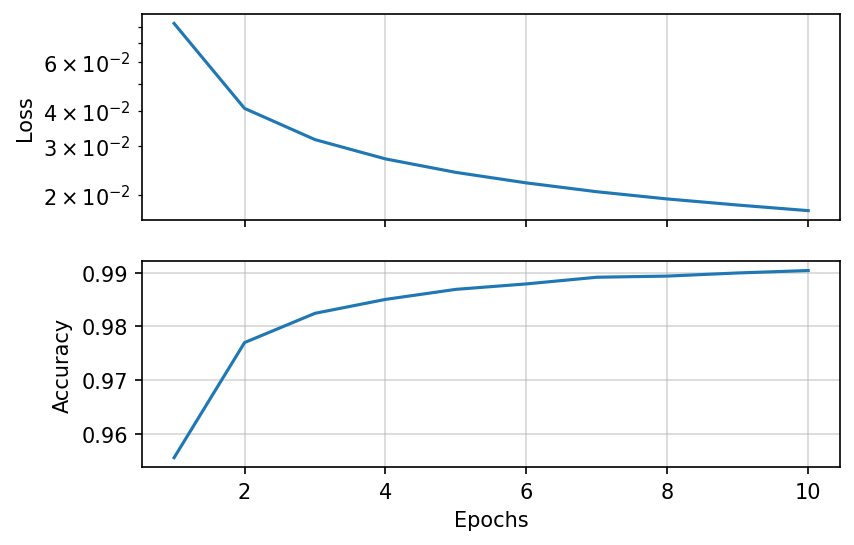

In [34]:
plot_history(lstm_history)

# One step ahead forecasting

In [35]:
selected = valid_Y
print(lstm_model.predict(valid_X[0:2,:,:]))


[[ 0.8943681   1.3980954  -1.2553551 ]
 [ 0.97548574  1.5107214  -1.1615405 ]]


In [36]:
forecast = lstm_model.predict(valid_X)
print(forecast.shape)

(119996, 3)


In [37]:

errorX = tf.keras.metrics.mean_squared_error(selected[:, 0], forecast[:, 0]).numpy()
print('RMSE X =', errorX)
errorY = tf.keras.metrics.mean_squared_error(selected[:, 1], forecast[:, 1]).numpy()
print('RMSE Y =', errorY)
errorZ = tf.keras.metrics.mean_squared_error(selected[:, 2], forecast[:, 2]).numpy()
print('RMSE Z =', errorZ)

RMSE X = 0.009203865
RMSE Y = 0.017161822
RMSE Z = 0.023192272


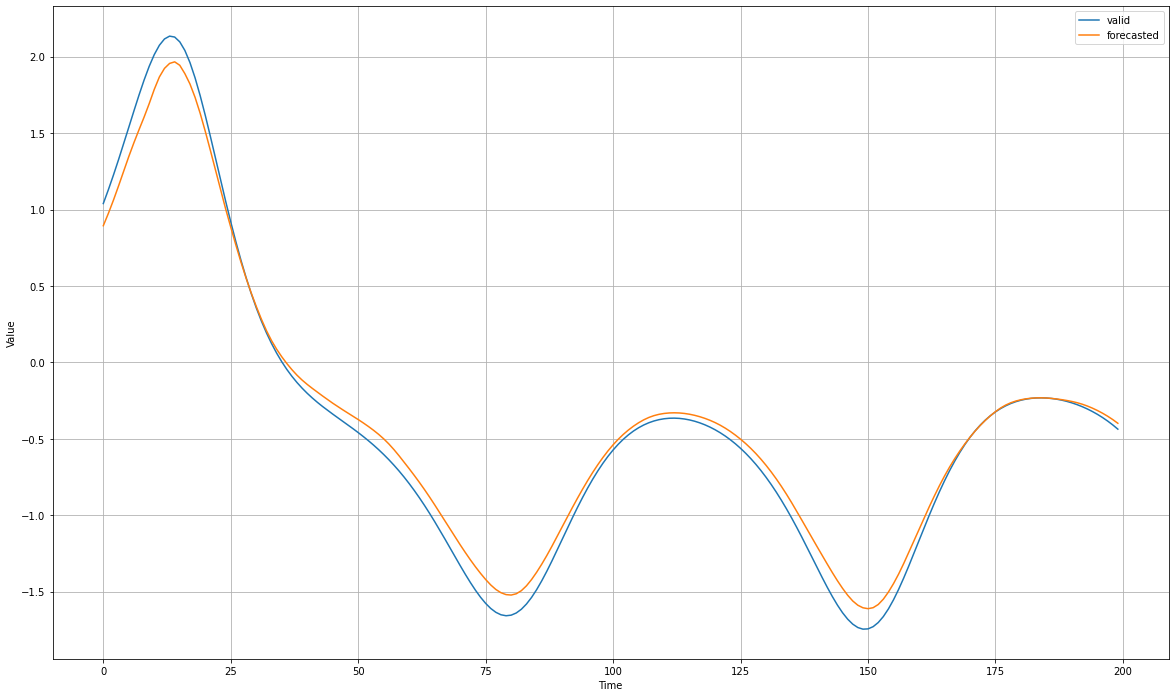

In [38]:
plt.figure(figsize=(20, 12))
plt.plot(selected[:200, 0], label='valid')
plt.plot(forecast[:200, 0], label='forecasted')
plt.legend()
plt.xlabel("Time")
plt.ylabel("Value")
plt.grid(True)


# Multiple step ahead forecasting

In [43]:
# forecast multiple step

forecast_time = 100
if len(valid_Y) - forecast_time < window_size : # check the possibility of forecasting
  print('Choose another time')
else:
  Y_mult = np.empty(shape=[0, 3]) # create empty array for storing forecasted Y values
  forecast_mult = valid_X[:1, :, :] # copy data for the first time step prediction
  for time in range(forecast_time):
    y = lstm_model.predict(forecast_mult[time:time+1,:,:]) # predict Y value
    Y_mult = np.append(Y_mult, y, axis=0) # save Y value
    print(y)
    forecast_mult = np.append(forecast_mult, np.empty(shape=[1, 20, 3]), axis=0) # add new empty sample 
    forecast_mult[time+1, :window_size-2, :] = forecast_mult[time, 1:window_size-1, :] # copy values from previous step except the last value
    forecast_mult[time+1, window_size-1, :] = y # add predicted value

print(forecast_mult.shape)
print(Y_mult.shape)

[[ 0.8943682  1.3980955 -1.255355 ]]
[[ 0.4163916  1.832919  -1.115108 ]]
[[ 0.63569945  1.9113493  -0.01671131]]
[[0.8512691 1.899385  0.9712583]]
[[0.9603847 1.7147361 1.8090478]]
[[0.94566447 1.5830886  2.0994163 ]]
[[1.0138048 1.4724554 2.226416 ]]
[[1.1227428 1.3735204 2.3218126]]
[[1.1623867 1.2864608 2.3631506]]
[[1.1510992 1.2213709 2.373454 ]]
[[1.1269208 1.1806608 2.3761492]]
[[1.1049427 1.1595762 2.378527 ]]
[[1.0886158 1.1524371 2.381598 ]]
[[1.0772699 1.154406  2.3846915]]
[[1.069123  1.1616745 2.3868694]]
[[1.0632298 1.1714953 2.3873386]]
[[1.0600826 1.1815332 2.3856778]]
[[1.0566007 1.1876101 2.3803253]]
[[1.0489752 1.1800805 2.367366 ]]
[[1.040365 1.151227 2.369791]]
[[1.0088503 0.9642352 2.3979375]]
[[0.92870563 0.8075688  2.4465663 ]]
[[0.8502289  0.62788105 2.4075043 ]]
[[0.86387426 0.5844656  2.3836646 ]]
[[0.93479925 0.56958497 2.3810127 ]]
[[1.0196851 0.483854  2.381024 ]]
[[1.1280236  0.36432412 2.3341367 ]]
[[1.2345043  0.24829762 2.2448273 ]]
[[1.254859   0.144

In [44]:
errorX = tf.keras.metrics.mean_squared_error(valid_Y[:forecast_time, 0], Y_mult[:, 0]).numpy()
print('RMSE X =', errorX)
errorY = tf.keras.metrics.mean_squared_error(valid_Y[:forecast_time, 1], Y_mult[:, 1]).numpy()
print('RMSE Y =', errorY)
errorZ = tf.keras.metrics.mean_squared_error(valid_Y[:forecast_time, 2], Y_mult[:, 2]).numpy()
print('RMSE Z =', errorZ)

RMSE X = 2.9644935135401242
RMSE Y = 1.190283971123176
RMSE Z = 1.588922998389212


In [45]:
print(valid_Y[:forecast_time, 0])
print(Y_mult[:, 0])

[ 1.03946845  1.13043102  1.22666457  1.32747633  1.43180822  1.53816979
  1.64458355  1.7485566   1.84709585  1.93678474  2.0139354   2.07482029
  2.11597103  2.13451269  2.12848386  2.09708473  2.04080246  1.96138522
  1.86166841  1.74528753  1.61633228  1.47900022  1.33729787  1.19481801
  1.05460219  0.91908134  0.79007869  0.66885551  0.55618214  0.45241956
  0.35760154  0.27151086  0.19374617  0.12377831  0.06099609  0.00474249
 -0.04565759 -0.09087666 -0.13156981 -0.16836453 -0.20185428 -0.23259488
 -0.26110306 -0.2878566  -0.31329574 -0.33782515 -0.36181663 -0.38561188
 -0.40952542 -0.43384743 -0.45884633 -0.4847711  -0.51185309 -0.54030742
 -0.57033369 -0.60211604 -0.63582237 -0.67160269 -0.70958639 -0.74987836
 -0.79255389 -0.83765212 -0.88516812 -0.93504347 -0.98715557 -1.04130576
 -1.09720685 -1.15447059 -1.21259625 -1.27096138 -1.3288167  -1.38528679
 -1.43937867 -1.49000016 -1.53598941 -1.57615595 -1.60933248 -1.63443487
 -1.65052606 -1.65687832 -1.65302724 -1.63881129 -1

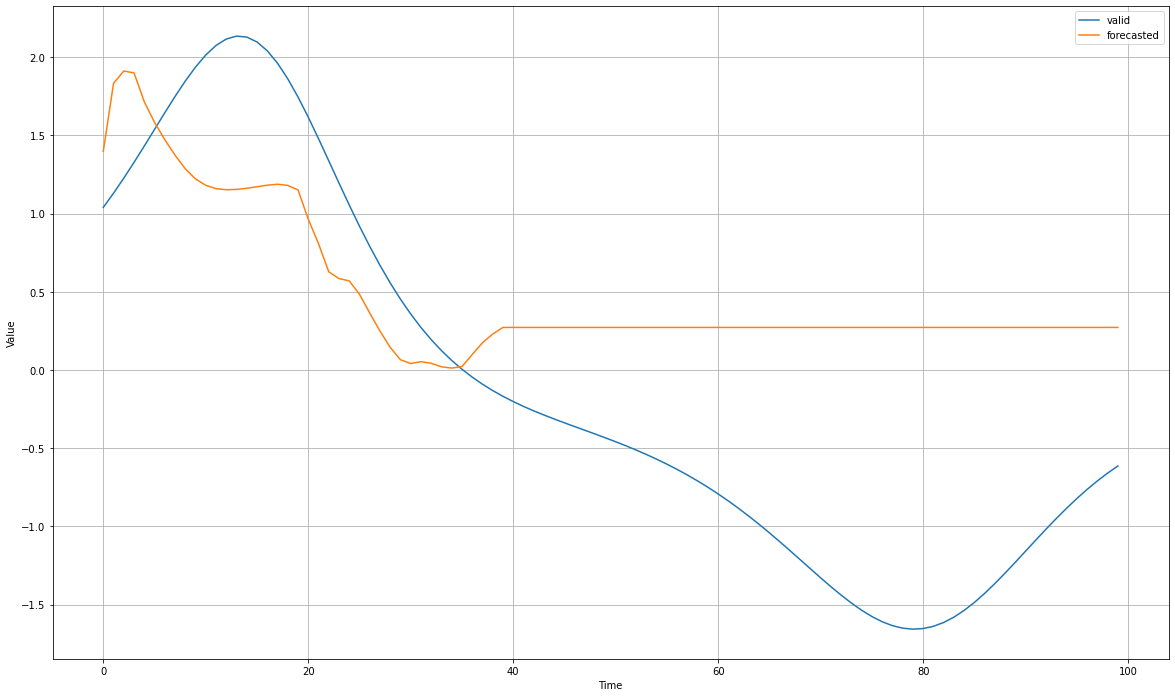

In [46]:
plt.figure(figsize=(20, 12))
plt.plot(valid_Y[:forecast_time, 0], label='valid')
plt.plot(Y_mult[:, 1], label='forecasted')
plt.legend()
plt.xlabel("Time")
plt.ylabel("Value")
plt.grid(True)